In [1]:
##### Always import all needed libraries in the first cell
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.svm import SVC
import pandas as pd
from string import punctuation
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Reshape
from keras import metrics
from keras import backend as K
from keras.utils import multi_gpu_model, CustomObjectScope
import random
import keras.backend.tensorflow_backend
import tensorflow as tf
from tqdm import tqdm
from keras.backend import clear_session

from sklearn.svm import SVC

from joblib import delayed, Parallel
np.random.seed(1) # this sets the seed so that the runs are consistent

%matplotlib inline

Using TensorFlow backend.


In [2]:
def cross_val(clf,X,y,name):
    print(name)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    print(metrics.classification_report(y, y_pred))
    conf = np.array(metrics.confusion_matrix(y, y_pred))
    print(conf)
    y_probas = clf.predict_proba(X)
#     skplt.metrics.plot_roc_curve(y, y_probas, title=name+' ROC Curves', curves='each_class')
    return metrics.f1_score(y,y_pred,pos_label=1, average='binary')

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def flatten(l):
    return [item for sublist in l for item in sublist]

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [3]:
dftrain_banned = pd.read_csv("../Data/Generated/200_words_10M_banned.csv", delimiter=',')
dftrain_banned.insert(0, "banned", 1)

dftrain_notbanned = pd.read_csv("../Data/Generated/200_words_10M_notbanned.csv", delimiter=',')
dftrain_notbanned.insert(0, "banned", 0)

dfTest = pd.read_csv("../Data/Generated/200_words_10M_test.csv", delimiter=',')
dfTest = dfTest.sample(frac=1)

dfTest["split"] = dfTest["words"].map(lambda x: x.split(" "), na_action='ignore')
dfTest["word_cnt"] = dfTest["split"].map(lambda x: len(x), na_action='ignore')
print("Test percent lost: %.2f" % (100*len(dfTest[dfTest["word_cnt"] != 200])/ len(dfTest)))
dfTest = dfTest[dfTest["word_cnt"] == 200]



Test percent lost: 5.63


In [4]:
def group_by_subreddit(df):
    subreddit_to_comments = {}
    for index, row in df.iterrows():
        if row["subreddit"] in subreddit_to_comments:
            subreddit_to_comments[row["subreddit"]] += [row["words"]]
        else:
            subreddit_to_comments[row["subreddit"]] = [row["words"]]
    return subreddit_to_comments
    
random.seed(42)
unique_subreddits = list(dfTest["subreddit"].value_counts().keys())
random.shuffle(unique_subreddits)
SUBREDDIT_CNT = len(unique_subreddits)

s1 = int (1/3 * SUBREDDIT_CNT)
s2 = int (2/3 * SUBREDDIT_CNT)

validation_test = unique_subreddits[:s1]

threshold_test = unique_subreddits[s1:s2]

testing_test = unique_subreddits[s2:]


dfVal = dfTest[dfTest["subreddit"].isin(validation_test)]
print(dfVal["banned"].sum()/ dfVal.shape[0])


dfThresh = dfTest[dfTest["subreddit"].isin(threshold_test)]
print(dfThresh["banned"].sum()/ dfThresh.shape[0])
threshSubreddits  = group_by_subreddit(dfThresh)

dfTestingTest = dfTest[dfTest["subreddit"].isin(testing_test)]
print(dfTestingTest["banned"].sum()/ dfTestingTest.shape[0])
testingTestSubreddits  = group_by_subreddit(dfTestingTest)


0.007058600188114284
0.004217345221947983
0.005303543218235162


In [5]:
TRAIN_BALANCE_RATIO = 20
TEST_BALANCE_RATIO = 185
TRAIN_N_COMMENTS = int(len(dftrain_banned)/5)
TEST_N_COMMENTS = int(len(dfVal)/10)

In [6]:
dfTest_banned = dfVal[dfVal["banned"]]
dfTest_notbanned = dfVal[dfVal["banned"] == False]

dfTest_balanced = pd.concat([dfTest_banned.head(n=TEST_N_COMMENTS), dfTest_notbanned.head(n=TEST_BALANCE_RATIO*TEST_N_COMMENTS)]).sample(frac=1)

In [7]:
dfTrain_banned_tmp = pd.concat([dftrain_banned.head(n=TRAIN_N_COMMENTS)]*int(TRAIN_BALANCE_RATIO))
dfTrain = pd.concat([dfTrain_banned_tmp, dftrain_notbanned.head(n=TRAIN_BALANCE_RATIO*TRAIN_N_COMMENTS)])

In [8]:
dfTrain[dfTrain["banned"]==1].shape, dfTrain[dfTrain["banned"]==0].shape

((30000, 2), (30000, 2))

In [9]:
dfTrain["split"] = dfTrain["words"].apply(lambda x: x.split(" "))
dfTrain["word_cnt"] = dfTrain["split"].apply(lambda x: len(x))
print("Train percent lost: %.2f" % (100*len(dfTrain[dfTrain["word_cnt"] != 200])/ len(dfTrain)))
dfTrain = dfTrain[dfTrain["word_cnt"]== 200]

Train percent lost: 1.04


In [10]:
dfTrain = dfTrain.sample(frac=1)
dfTrain.head(n=10)

,banned,words,split,word_cnt
4821,0,enough to submit content to /r/videos at this ...,"[enough, to, submit, content, to, /r/videos, a...",200
2505,0,I still play it since I 've got old and I 've ...,"[I, still, play, it, since, I, 've, got, old, ...",200
12072,0,try to control what he talks about with other ...,"[try, to, control, what, he, talks, about, wit...",200
674,1,"much in agreement that if anything happens , w...","[much, in, agreement, that, if, anything, happ...",200
22272,0,. Not to mention their two young children . /r...,"[., Not, to, mention, their, two, young, child...",200
24287,0,"tongue in cheek and had concluded my OP with ,...","[tongue, in, cheek, and, had, concluded, my, O...",200
9304,0,undefeated in the league . 🙌 Except catch Than...,"[undefeated, in, the, league, ., 🙌, Except, ca...",200
19132,0,", if you 're not testing the sexual compatibil...","[,, if, you, 're, not, testing, the, sexual, c...",200
1211,1,! hell of an offer ! thats for damn sure ... g...,"[!, hell, of, an, offer, !, thats, for, damn, ...",200
20222,0,. It 's going to be different from the Nexus p...,"[., It, 's, going, to, be, different, from, th...",200


In [11]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(dfTrain["words"])
y_train = dfTrain["banned"]

X_test = vectorizer.transform(dfTest_balanced["words"])
y_test = dfTest_balanced["banned"]

In [12]:
model_filename = "../Data/Models/20_to_1_train/weights-20-ratio.hdf5"

with CustomObjectScope({"f1_m": f1_m, "recall_m":recall_m, "precision_m":precision_m, "binary_focal_loss_fixed": binary_focal_loss(alpha=.25, gamma=2)}):
    model_loaded = load_model(model_filename)
    parallel_model = multi_gpu_model(model_loaded, gpus=8, cpu_merge=False)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
subreddit_list = threshSubreddits.keys()

to_process = []
for subreddit in subreddit_list:
    to_process += threshSubreddits[subreddit]

# to_process = flatten(threshSubreddits.values())
X_thresh = vectorizer.transform(to_process)
# res =  parallel_model.predict(X_thresh)

# def predict_batch(examples):
#     X_thresh = vectorizer.transform(examples)
#     return parallel_model.predict(X_thresh, batch_size=32)
    
# # predict_batch(threshSubreddits["fakeid"])
# predictions = Parallel(n_jobs=-1)(delayed(predict_batch)(examples) for examples in tqdm(threshSubreddits.values()))
# # thresh_predications = {}

# for subreddit, examples in tqdm(threshSubreddits.items()):
#     X_thresh = vectorizer.transform(examples)
#     print(len(examples), len(threshSubreddits), flush=True)    
#     thresh_predications[subreddit] = model_loaded.predict(X_thresh, batch_size=len(examples))


In [14]:
# preds = []
# for i in tqdm(range(int(len(to_process)/2000))):
#     preds += list(parallel_model.predict(X_thresh[i*2000:(i+1)*2000]).flatten())
#     print(len(preds), preds[-2:])
preds = parallel_model.predict(X_thresh, verbose=True, batch_size=1024)

134919/134919 [==============================] - 136s 1ms/step


In [15]:
preds.shape

(134919, 1)

In [15]:
import copy
subreddit_to_preds = {}
my_preds = copy.deepcopy(preds)
i = 0
for subreddit in subreddit_list:
    n_examples = len(threshSubreddits[subreddit])
    subreddit_to_preds[subreddit] = my_preds[i:i+n_examples]
    i += n_examples
#     subreddit_keys.append([subreddit] * len(examples))


In [162]:
# for subreddit, examples in threshSubreddits.items():
#     print(len(examples), len(subreddit_to_preds[subreddit]))
def read_banned_subreddits(filename):
    """read in banned subreddits file with each line as 'r/asfasdf' """
    with open(filename, "r") as f:
        banned = set()
        for line in f:
            if line.strip() != "":
                banned.update([line.strip().split("r/")[1]])
        return banned

banned_subreddits = read_banned_subreddits("../Data/banned-subreddits.txt")
    
subreddit_to_avg = {}
for subreddit, preds in subreddit_to_preds.items():
    if preds is not None and len(preds) > 0:
        subreddit_to_avg[subreddit] = np.mean(preds)
    
banned_means = [(mean, "banned", True) for subreddit, mean in subreddit_to_avg.items() 
                if subreddit in banned_subreddits]
notbanned_means = [(mean, "notbanned", False) for subreddit, mean in subreddit_to_avg.items() 
                if subreddit not in banned_subreddits]

predicted_outputs = pd.DataFrame(banned_means + notbanned_means, columns=["mean", "class", "isbanned"])


# svm_model = SVC(gamma="scale")

# svm_model.fit([[mean] for mean in svm_input["mean"]], svm_input["isbanned"])
# svm_model.__dict__

# sorted_preds = sorted(flatten(subreddit_to_preds.values()))
# num_examples = len(sorted_preds)
# idx = int(num_examples* (182/183))
# ratio = sorted_preds[idx]

# import matplotlib.pyplot as plt
# plt.plot(sorted_preds)
# print(ratio)

# ratio = 0.01


# print(sum(np.array([x for x,y in banned_means]) > ratio) / len(banned_means))
# print(sum(np.array([x for x,y in notbanned_means]) < ratio) / len(notbanned_means))

# means = np.array(sorted(subreddit_to_avg.values()))


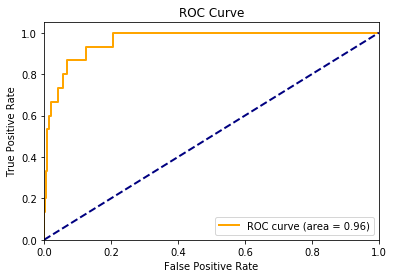

In [163]:
fpr, tpr, threshold = skplt.metrics.roc_curve(predicted_outputs["isbanned"], predicted_outputs["mean"])
area_under = auc(fpr, tpr)

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


# cmap = np.log(1-threshold)
# sm = ScalarMappable(norm=Normalize(vmin=min(cmap), vmax=max(cmap)), cmap="viridis")



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve (area = %0.2f)' % area_under)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("roc.pdf")
plt.show()

# print(tpr)
idx = list(tpr).index(0.8666666666666666666)
FINAL_THRESHOLD = threshold[idx]
FINAL_THRESHOLD = 0.01
# tpr


              precision    recall  f1-score   support

       False       0.91      1.00      0.95      2692
        True       0.87      0.05      0.09       269

   micro avg       0.91      0.91      0.91      2961
   macro avg       0.89      0.52      0.52      2961
weighted avg       0.91      0.91      0.88      2961

[[2690    2]
 [ 256   13]]
[[0.91310251 0.13333333]
 [0.08689749 0.86666667]]


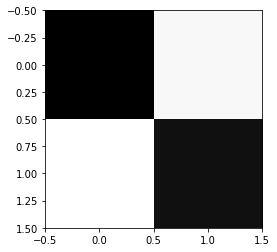

In [164]:
# confusion for threshold set
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import scikitplot as skplt


predicted_outputs["prediction"] = predicted_outputs["mean"] > FINAL_THRESHOLD


print(classification_report(predicted_outputs["prediction"], predicted_outputs["isbanned"]))
# print(predicted_outputs[predicted_outputs["isbanned"]])
confu = confusion_matrix(predicted_outputs["prediction"], predicted_outputs["isbanned"])
print(confu)
print(confu / np.sum(confu, axis=0))
plt.imshow(confu / np.sum(confu, axis=0), cmap="Greys")
# plt.axis('off')
plt.show()


In [102]:
test_subreddit_list = testingTestSubreddits.keys()

test_to_process = []
for subreddit in test_subreddit_list:
    test_to_process += testingTestSubreddits[subreddit]

# to_process = flatten(threshSubreddits.values())
X_test = vectorizer.transform(test_to_process)
# res =  parallel_model.predict(X_thresh)

test_preds = parallel_model.predict(X_test, verbose=True, batch_size=1024)

88620/88620 [==============================] - 78s 884us/step


In [165]:
# real test set!

import copy
subreddit_test_preds = {}
my_test_preds = copy.deepcopy(test_preds)
i = 0
for subreddit in test_subreddit_list:
    n_examples = len(testingTestSubreddits[subreddit])
    subreddit_test_preds[subreddit] = my_test_preds[i:i+n_examples]
    i += n_examples
#     subreddit_keys.append([subreddit] * len(examples))


# for subreddit, examples in threshSubreddits.items():
#     print(len(examples), len(subreddit_to_preds[subreddit]))
def read_banned_subreddits(filename):
    """read in banned subreddits file with each line as 'r/asfasdf' """
    with open(filename, "r") as f:
        banned = set()
        for line in f:
            if line.strip() != "":
                banned.update([line.strip().split("r/")[1]])
        return banned

banned_subreddits = read_banned_subreddits("../Data/banned-subreddits.txt")
    
subreddit_test_avg = {}
for subreddit, preds in subreddit_test_preds.items():
    if preds is not None and len(preds) > 0:
        subreddit_test_avg[subreddit] = np.mean(preds)
    
test_banned_means = [(mean, "banned", True) for subreddit, mean in subreddit_test_avg.items() 
                if subreddit in banned_subreddits]
test_notbanned_means = [(mean, "notbanned", False) for subreddit, mean in subreddit_test_avg.items() 
                if subreddit not in banned_subreddits]


test_predicted_outputs = pd.DataFrame(test_banned_means + test_notbanned_means, columns=["mean", "class", "isbanned"])
test_predicted_outputs["prediction"] = test_predicted_outputs["mean"] > FINAL_THRESHOLD
print(classification_report(test_predicted_outputs["prediction"], test_predicted_outputs["isbanned"]))
confu = confusion_matrix(test_predicted_outputs["prediction"], test_predicted_outputs["isbanned"])
print(confu)

              precision    recall  f1-score   support

       False       0.92      1.00      0.96      2700
        True       0.80      0.05      0.09       262

   micro avg       0.91      0.91      0.91      2962
   macro avg       0.86      0.52      0.52      2962
weighted avg       0.90      0.91      0.88      2962

[[2697    3]
 [ 250   12]]


In [76]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(predicted_outputs["prediction"][:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# fpr, tpr, thresholds = roc_curve(predicted_outputs["prediction"], predicted_outputs["isbanned"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


ValueError: Can only tuple-index with a MultiIndex

In [166]:
from keras.utils import plot_model
plot_model(parallel_model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [65]:
import pickle
sorted_preds = sorted(flatten(subreddit_to_preds.values()))
num_examples = len(sorted_preds)
idx = int(num_examples* (1/186))
print(idx)
sorted_preds[-idx]
pickle.dump(subreddit_to_preds, open("../Data/Cached/Predictions.pkl", "wb"))

104


In [66]:
input_dim = X_train.shape[1]  # Number of features
print(X_train.shape)
print(input_dim)

model = Sequential()


model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))

# model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
# model.add(layers.Dropout(0.5))


model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
# model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

(59377, 142111)
142111


In [67]:
parallel_model = multi_gpu_model(model, gpus=8, cpu_merge=False)
parallel_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',f1_m,precision_m, recall_m])
parallel_model.summary()

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['acc',f1_m,precision_m, recall_m])
# model.summary()

KeyboardInterrupt: 

In [ ]:
history = parallel_model.fit(X_train, y_train,
                    epochs=2,
                    verbose=True,
                    validation_data=(X_test[:10000], y_test[:10000]),
                    batch_size=1024)

In [ ]:
parallel_model.save("../Data/Cached/Model.h5")

In [129]:
with CustomObjectScope({"f1_m": f1_m, "cross_val":cross_val, "recall_m":recall_m, "precision_m":precision_m}):
    model_loaded = load_model("../Data/Cached/Model.h5")

In [ ]:
# X_thresh = vectorizer.transform(flatten(threshSubreddits.values()))

def predict_batch(examples):
    X_thresh = vectorizer.transform(examples)
    return parallel_model.predict(X_thresh, batch_size=256)
    
    
predictions = Parallel(n_jobs=-1)(delayed(predict_batch)(examples) for examples in tqdm(threshSubreddits.values()))

# for subreddit, examples in threshSubreddits.items():
#     X_thresh = vectorizer.transform(examples)
#     print(len(examples), flush=True)
#     thresh_predications[subreddit] = parallel_model.predict(X_thresh, batch_size=len(examples))
    

In [135]:
parallel_model.__dict__

{'_uses_inputs_arg': True,
 'inputs': [<tf.Tensor 'dense_6_input:0' shape=(?, 193952) dtype=float32>],
 'outputs': [<tf.Tensor 'dense_10_1/concat:0' shape=(?, 1) dtype=float32>],
 'name': 'model_2',
 'trainable': True,
 '_is_compiled': True,
 '_expects_training_arg': False,
 '_initial_weights': None,
 'supports_masking': False,
 'optimizer': <keras.optimizers.Adam at 0x2b5b6e8ec278>,
 '_updates': [],
 '_losses': [],
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_layers': [<keras.engine.input_layer.InputLayer at 0x2b5e26dce668>,
 '_outbound_nodes': [],
 '_inbound_nodes': [<keras.engine.base_layer.Node at 0x2b5e26c66278>],
 '_compute_previous_mask': True,
 '_built': True,
 '_is_graph_network': True,
 '_input_layers': [<keras.engine.input_layer.InputLayer at 0x2b5e26dce668>],
 '_output_layers': [<keras.layers.merge.Concatenate at 0x2b5e26c66048>],
 '_input_coordinates': [(<keras.engine.input_layer.InputLayer at 0x2b5e26dce668>,
   0,
   0)],
 '_output_coordinates': [(<keras.layer

In [132]:
prediction = model_loaded.predict(X_thresh, use_multiprocessing=True)


TypeError: predict() got an unexpected keyword argument 'use_multiprocessing'

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)